In [478]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

# Data

In [479]:
def generate_line(n, sign = "+"):
    t = torch.linspace(-3 * torch.pi, 3 * torch.pi, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1) 
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_parabola(n, sign = "+"):
    t = torch.linspace(-3 * torch.pi, 3 * torch.pi, n)
    x = (t).view(-1, 1)
    if sign == "+":
        y = (t**2).view(-1, 1)
    else:
        y = -(t**2).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_circle(n, r = 1):
    t = torch.linspace(-3 * torch.pi, 3 * torch.pi, n)
    x = (r * torch.cos(t)).view(-1, 1)
    y = (r * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_data(n, sign = "+"):
    line = generate_line(n, sign)
    parabola = generate_parabola(n, sign)
    circle = generate_circle(n)
    return torch.concat((line, parabola), dim=0)

def plot_data(data):
    data = data.to("cpu").detach().numpy()
    for i in range(data.shape[0]):
        plt.scatter(data[i, :, 0], data[i, :, 1], s=1.5)
    plt.show()

# fIMLE Helpers

In [480]:
class H_theta(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

def generate_NN_latent_functions(num_samples, xdim=1, zdim=2, lambda_value=1):
    # Define the neural network class
    class NN(nn.Module):
        
        def __init__(self, input_dim, output_dim):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 50)
            self.fc2 = nn.Linear(50, 100)
            self.fc3 = nn.Linear(100, output_dim)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Custom weight initialization function
    def weights_init_normal(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain=1.0)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # Generate and initialize the neural networks
    networks = []
    for _ in range(num_samples):
        net = NN(xdim, zdim)
        net.apply(weights_init_normal)
        networks.append(net)
    
    return networks



def find_nns(Y, G):
    Y = Y.unsqueeze(0)
    result = torch.empty(G.shape[0])
    for i in range(G.shape[0]):
        diffs = (((G[i, :, 0] - Y[0, :, 0]) ** 2 + (G[i, :, 1] - Y[0, :, 1]) ** 2)).sum()
        result[i] = diffs
    return torch.argmin(result).item()

def f_loss(Y, G):
    
    num_curves = Y.shape[0]
    total_loss = 0.0
    for i in range(num_curves):
        diffs = torch.sum((G[i, :, :] - Y[i, :, :]) ** 2, dim=1)
        total_loss += diffs.mean()

    result = total_loss / num_curves
    return result

# fIMLE Training

In [481]:
epochs = 5000
staleness = 10
num_Z_samples = 40
lr = 0.001
num_points = 200
xdim = 1
zdim = 5

x shape: torch.Size([200, 1])
points shape: torch.Size([2, 200, 2])


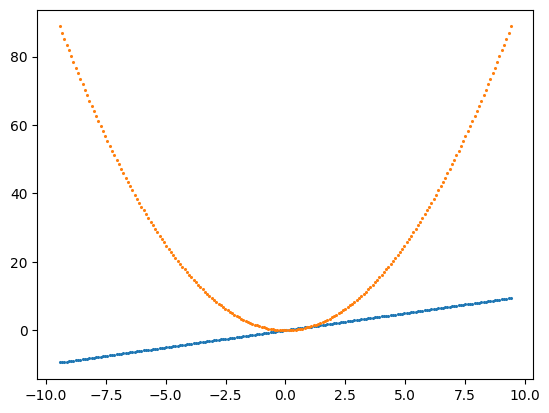

In [482]:
t = torch.linspace(-3*torch.pi, 3*torch.pi, num_points).to(device).unsqueeze(1)
points = generate_data(num_points).to(device)
print(f"x shape:", t.shape)
print(f"points shape:", points.shape)
plot_data(points)

100%|██████████| 5000/5000 [00:34<00:00, 143.27it/s]


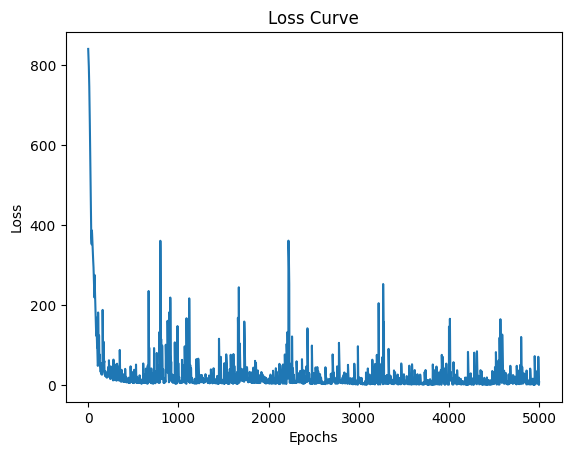

8.124404907226562


In [483]:
H_t = H_theta(input_dim=zdim+1, output_dim=2).to(device)
optimizer = optim.Adam(H_t.parameters(), lr=lr)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)
losses = []

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            Zs = generate_NN_latent_functions(num_Z_samples, xdim, zdim, lambda_value=1)
            Zxs = torch.empty((num_Z_samples, num_points, zdim+1)).to(device)
            for i, model in enumerate(Zs):
                model = model.to(device)
                Zx = model(t)
                Zx = torch.cat((Zx, t), dim = 1)
                Zxs[i] = Zx
            generated = H_t(Zxs) 
            imle_nns = torch.tensor([find_nns(d, generated) for d in points], dtype=torch.long)
            imle_nn_z = [Zs[idx] for idx in imle_nns]

    optimizer.zero_grad()
    imle_transformed_points = torch.empty((points.shape[0], num_points, zdim+1)).to(device)
    for i, model in enumerate(imle_nn_z):
        model = model.to(device)
        Zx = model(t)  
        Zx = torch.cat((Zx, t), dim = 1)
        imle_transformed_points[i] = Zx

    outs = H_t(imle_transformed_points) 
    loss = f_loss(outs, points)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    #scheduler.step()


plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()
print(losses.pop())

torch.Size([1000, 1])


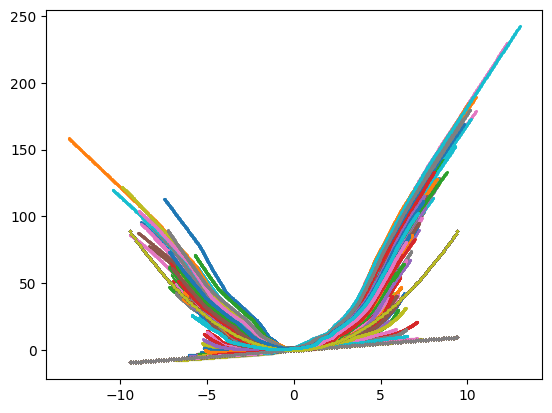

In [485]:
t = torch.linspace(- 2*torch.pi, 2*torch.pi, 1000)
t = t.unsqueeze(1).to(device)
print(t.shape)




for i in range(100):
    Zs = generate_NN_latent_functions(1, xdim, zdim)[0].to(device)
    Z = Zs(t)
    Z = torch.cat((Z, t), dim = 1)
    out = H_t(Z)
    data = points.to("cpu").detach().numpy()
    for i in range(data.shape[0]):
        plt.scatter(data[i, :, 0], data[i, :, 1], s=1.5)
    plt.scatter(out[:, 0].to('cpu').detach().numpy(), out[:, 1].to('cpu').detach().numpy(), s = 1.5)
plt.show()

In [ ]:
import imageio

# Assuming generate_NN_latent_functions, H_t, t, points, xdim, zdim, and device are defined elsewhere

# List to store the file paths of the generated images
image_paths = []

for i in range(100):
    Zs = generate_NN_latent_functions(1, xdim, zdim)[0].to(device)
    Z = Zs(t)
    Z = torch.cat((Z, t), dim = 1)
    out = H_t(Z)
    data = points.to("cpu").detach().numpy()
    
    plt.figure(figsize=(8, 6))
    for j in range(data.shape[0]):
        plt.scatter(data[j, :, 0], data[j, :, 1], s=1.5)
    plt.scatter(out[:, 0].to('cpu').detach().numpy(), out[:, 1].to('cpu').detach().numpy(), s=1.5)
    
    # Save the current plot as an image
    image_path = f'frame_{i:03d}.png'
    plt.savefig(image_path)
    image_paths.append(image_path)
    plt.close()

# Create a GIF from the saved images
with imageio.get_writer('animation.gif', mode='I', duration=0.1) as writer:
    for image_path in image_paths:
        image = imageio.imread(image_path)
        writer.append_data(image)

# Optionally, clean up the image files after creating the GIF
import os
for image_path in image_paths:
    os.remove(image_path)

print("GIF created successfully.")